In [2]:
import sys
sys.path.append('../src')
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from geoq.clay import wrapper
import numpy as np
from einops import rearrange, reduce, repeat
from glob import glob
from tqdm import tqdm
from loguru import logger

/home/raulramos/conda/envs/lunarlab-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generating image embeddings

This notebook shows how to generate the image embeddings present in the dataset. You can use it to generate embeddings of new images, or regenerate the embeddings of the full dataset.

## Load pretrained Clay model

In [2]:
MODEL_PATH = '/datasets/genai-geo-embeddings/claymodel-weights'
cw = wrapper.ClayWrapper(path=MODEL_PATH)


2025-08-10 14:14:01.771 | INFO     | geoembs.clay.wrapper:__init__:36 - using device cuda
2025-08-10 14:14:01.772 | INFO     | geoembs.clay.wrapper:__init__:38 - creating clay model instance
2025-08-10 14:14:07.226 | INFO     | geoembs.clay.wrapper:__init__:56 - loading clay model weights
2025-08-10 14:14:08.090 | INFO     | geoembs.clay.wrapper:__init__:66 - done


## Get list of all available files

In [3]:
chip_files = glob('/datasets/genai-geo-embeddings/chips/*')
len(chip_files)

48313

## Load a single chip. Observe the pixel distributions

imgs must be arrays of `uint8`, so pixel values must be between 0 and 255

2025-08-10 14:57:25.415 | INFO     | __main__:<module>:2 - loading /datasets/genai-geo-embeddings/chips/34250c11fccd8.pkl
2025-08-10 14:57:25.417 | INFO     | __main__:<module>:7 - chip keys dict_keys(['chipset_id', 'chip_id', 'season', 'description', 'img', 'geometry', 'image_embedding', 'text_embedding', 'lonlat'])
2025-08-10 14:57:25.417 | INFO     | __main__:<module>:8 - showiing img
2025-08-10 14:57:25.418 | INFO     | __main__:<module>:9 - img shape is (512, 512, 3)
2025-08-10 14:57:25.418 | INFO     | __main__:<module>:10 - img type is uint8


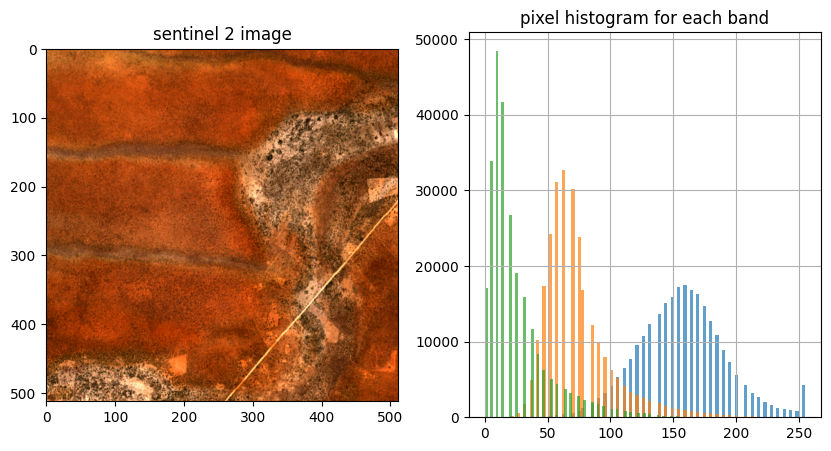

In [15]:
cfile = np.random.choice(chip_files)
logger.info(f'loading {cfile}')

with open(cfile, 'rb') as f:
    c = pickle.load(f)

logger.info(f'chip keys {c.keys()}')
logger.info('showiing img')
logger.info(f"img shape is {c['img'].shape}")
logger.info(f"img type is {c['img'].dtype}")

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1,2)
ax = axs[0]
ax.imshow(c['img'])
ax.set_title(f'sentinel 2 image')

ax = axs[1]
for i in range(3):
    ax.hist(c['img'][:,:,i].flatten(), bins=100, alpha=.7)
ax.set_title(f'pixel histogram for each band')
ax.grid();

## Get the embeddings of the chip

2025-08-10 14:57:29.377 | INFO     | __main__:<module>:2 - batch shape is (1, 3, 512, 512)
2025-08-10 14:57:29.423 | INFO     | __main__:<module>:5 - embeddings shape is (1, 1024)


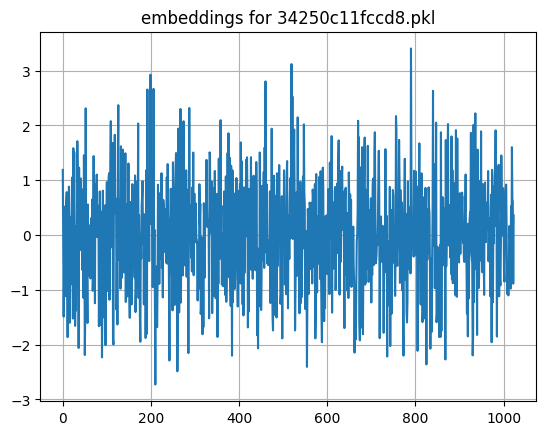

In [16]:
batch = np.transpose(np.r_[c['img'][np.newaxis,:]], (0,3,1,2))
logger.info(f"batch shape is {batch.shape}")

embeddings = cw.batch_embeddings(batch)
logger.info(f"embeddings shape is {embeddings.shape}")

plt.plot(embeddings[0])
plt.title(f'embeddings for {cfile.split("/")[-1]}')
plt.grid()

## They are the same embeddings stored in the dataset

allowing for numeric representation precision errors

Text(0, 0.5, 'as copmuted from the model')

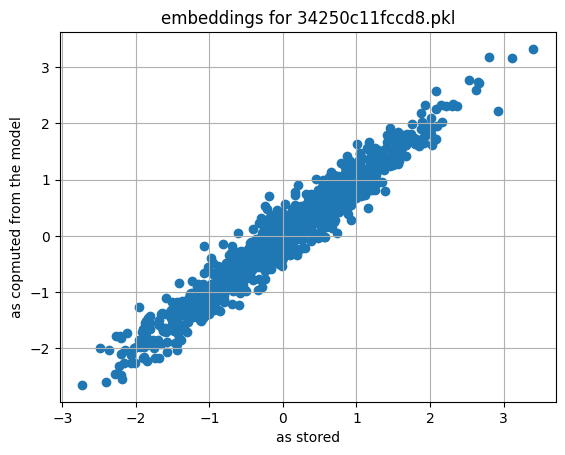

In [17]:
plt.scatter(embeddings[0], c['image_embedding'])
plt.title(f'embeddings for {cfile.split("/")[-1]}')
plt.grid()
plt.xlabel('as stored')
plt.ylabel('as copmuted from the model')

## Now get embeddings for all chips

In [10]:
batch_size = 4

In [11]:
embeddings = []
for i in tqdm(range(0, len(chip_files), batch_size)):
    batch = []
    bs = batch_size if i+batch_size<len(chip_files) else len(chip_files)-i
    for ii in range(bs):
        with open(chip_files[i+ii],'rb') as f:
            z = pickle.load(f)
        batch.append(z['img'])

    batch = np.transpose(np.r_[batch], (0,3,1,2))
    ez = cw.batch_embeddings(batch, standardize=True)
    for ezi in ez:
        embeddings.append(ezi)
embeddings = np.r_[embeddings]
embeddings.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12079/12079 [20:15<00:00,  9.93it/s]


(48313, 1024)

## Observe that embeddings are standardized wrt to this dataset

Element-wise mean and stdev are 0 and 1

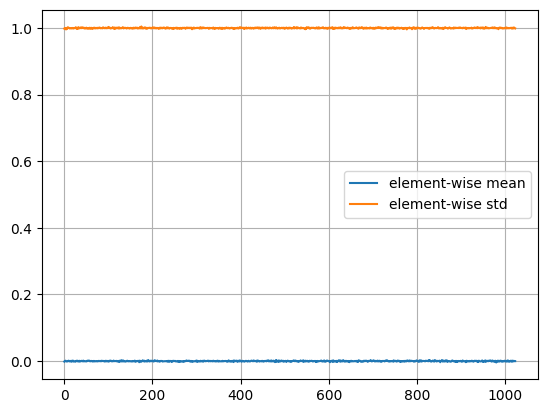

In [12]:
plt.plot(embeddings.mean(axis=0), label='element-wise mean')
plt.plot(embeddings.std(axis=0), label='element-wise std')
plt.grid()
plt.legend();

## Optionally rewrite them to the dataset

In [14]:
for fname, emb in tqdm(zip(chip_files, embeddings), total=len(chip_files)):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
    
    z['image_embedding'] = emb
    
    with open(fname, 'wb') as f:
        pickle.dump(z, f)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48313/48313 [00:47<00:00, 1014.29it/s]
